In [1]:
import pandas as pd

# 加载数据
df = pd.read_csv('../data/air/城市_20220101-20221231/china_cities_20220102.csv')

# 显示数据类型
print(df.dtypes)

date      int64
hour      int64
type     object
北京      float64
天津      float64
         ...   
兰州新区    float64
赣江新区    float64
儋州      float64
雄安新区    float64
西咸新区    float64
Length: 378, dtype: object


In [2]:
# 使用melt将城市列转为行
df_melted= df.melt(id_vars=['date', 'hour', 'type'], var_name='City', value_name='Value')

# 处理缺失值
df_melted.fillna(method='ffill', inplace=True)

# 删除重复行
df_melted.drop_duplicates(inplace=True)

# 显示转化后的数据类型
print(df_melted.dtypes)

# 显示前10行数据
print(df_melted.head())

date       int64
hour       int64
type      object
City      object
Value    float64
dtype: object
       date  hour       type City  Value
0  20220102     0        AQI   北京   17.0
1  20220102     0      PM2.5   北京    6.0
2  20220102     0  PM2.5_24h   北京   24.0
3  20220102     0       PM10   北京   15.0
4  20220102     0   PM10_24h   北京   54.0


/var/folders/2d/fxsd9j2x5c1_4_6qtgkldkmm0000gn/T/ipykernel_18478/2215625537.py:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_melted.fillna(method='ffill', inplace=True)


In [20]:
# 统计每列中空值的数量
df_melted.isnull().sum()

date                   0
hour                   0
type                   0
City                   0
Value                  0
is_anomalous           0
min_value_invalid      0
max_value_invalid      0
PM_relation_invalid    0
dtype: int64

In [3]:
# 将日期转换为日期时间格式，确保‘hour’在正确范围内
df_melted['date'] = pd.to_datetime(df_melted['date'], format='%Y%m%d')
df_melted = df_melted[df_melted['hour'].between(0, 23)]  # 确保小时在0到23之间

# 处理缺失值，使用前向填充方法填补空缺数据
df_melted.fillna(method='ffill', inplace=True)

# 显示数据基本信息
df_melted.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135000 entries, 0 to 134999
Data columns (total 5 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   date    135000 non-null  datetime64[ns]
 1   hour    135000 non-null  int64         
 2   type    135000 non-null  object        
 3   City    135000 non-null  object        
 4   Value   135000 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(2)
memory usage: 5.1+ MB


/var/folders/2d/fxsd9j2x5c1_4_6qtgkldkmm0000gn/T/ipykernel_18478/2582630321.py:6: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_melted.fillna(method='ffill', inplace=True)


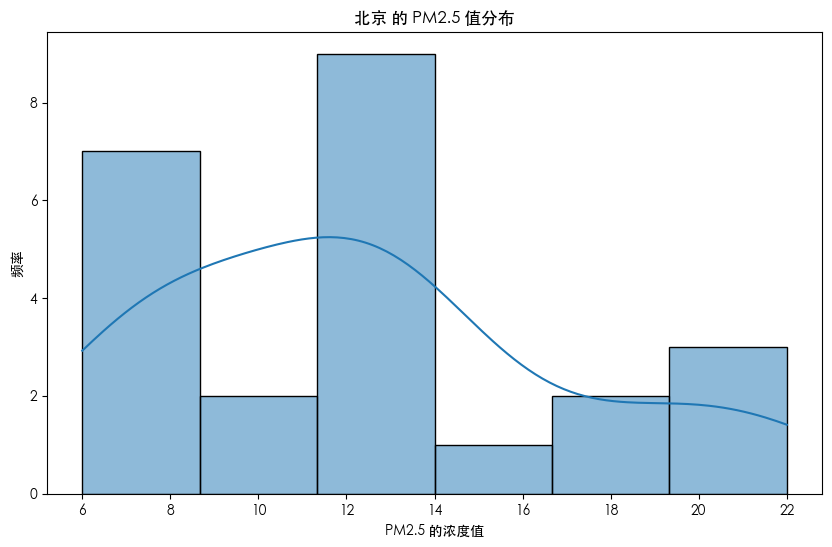

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import matplotlib.font_manager as fm

# 查找系统中的中文字体
zh_fonts = [f.name for f in fm.fontManager.ttflist if 'CN' in f.name or 'Kai' in f.name or 'Hei' in f.name]

# 如果找到了可用的中文字体，使用第一个找到的
if zh_fonts:
    plt.rcParams['font.sans-serif'] = [zh_fonts[1]]  # 自动选择系统中的可用中文字体 (我使用了找到的第二个字体)
else:
    print("未找到中文字体，确保系统中安装了中文字体。")

plt.rcParams['axes.unicode_minus'] = False  # 解决坐标轴负号显示问题

# 模拟加载的空气质量数据
# 假设 df_melted 是已经清洗后的数据

# 手动选择城市和污染物
selected_city = '北京'  # 你可以手动更改这个城市名称
selected_pollutant = 'PM2.5'  # 你可以手动更改污染物类型，例如：'PM2.5', 'AQI', 'PM10', 'SO2'

# 绘制选定城市和污染物的值分布
plt.figure(figsize=(10, 6))
df_filtered = df_melted[(df_melted['City'] == selected_city) & (df_melted['type'] == selected_pollutant)]
sns.histplot(data=df_filtered, x='Value', kde=True)
plt.title(f'{selected_city} 的 {selected_pollutant} 值分布')
plt.xlabel(f'{selected_pollutant} 的浓度值')
plt.ylabel('频率')
plt.show()

# 绘制选定城市的AQI时间趋势（如果选择的是AQI）
if selected_pollutant == 'AQI':
    df_melted_aqi = df_melted[(df_melted['City'] == selected_city) & (df_melted['type'] == 'AQI')]  # 筛选出该城市的AQI数据
    if df_melted_aqi.empty:
        print(f"{selected_city} 没有AQI数据")
    else:
        plt.figure(figsize=(12, 6))
        sns.lineplot(data=df_melted_aqi, x='date', y='Value')
        plt.title(f'{selected_city} 的AQI时间趋势')
        plt.xlabel('日期')
        plt.ylabel('AQI值')
        plt.show()

In [5]:
def min_value_check(df, pollutant, min_threshold):
    return df['Value'] < min_threshold

In [6]:
def max_value_check(df, pollutant, max_threshold):
    return df['Value'] > max_threshold

In [7]:
def critical_value_check(df, pollutant, min_threshold):
    df['Value'] = df['Value'].apply(lambda x: max(x, min_threshold / 2))
    return df

In [8]:
def logic_check(df):
    # 创建一个空列用于标记PM2.5和PM10之间的关系是否异常
    df['PM_relation_invalid'] = False

    # 遍历所有城市的每个时间点
    for name, group in df.groupby(['City', 'date', 'hour']):
        # 获取该时间点的PM2.5和PM10的值
        pm25_value = group[group['type'] == 'PM2.5']['Value']
        pm10_value = group[group['type'] == 'PM10']['Value']
        
        # 如果PM2.5和PM10的数据都存在，且仅有一个值可比较
        if len(pm25_value) == 1 and len(pm10_value) == 1:
            pm25 = pm25_value.iloc[0]
            pm10 = pm10_value.iloc[0]
            
            # 如果PM2.5 > PM10，则标记PM2.5行为True
            if pm25 > pm10:
                # 仅标记PM2.5行为True，而不影响其他污染物类型
                df.loc[group[group['type'] == 'PM2.5'].index, 'PM_relation_invalid'] = True
                
            # 输出该组的所有数据
                print(f"异常数据检测 - City: {name[0]}, Date: {name[1]}, Hour: {name[2]}")
                print(group)
                print("-" * 40)  # 分隔线用于输出结果之间的区分
    return df

In [9]:
def variation_check(df, threshold=7, pollutants=['AQI', 'PM2.5', 'PM10', 'NO2', 'CO', 'O3', 'SO2']):
    """
    检查每个城市和指定污染物的数值变化，判断是否存在大幅波动。
    :param df: 数据框
    :param threshold: 控制大幅波动的阈值系数（默认是7倍标准差）
    :param pollutants: 需要监测的大气污染物列表
    :return: 带有波动异常标记的数据框
    """
    # 仅筛选出特定污染物的数据
    df = df[df['type'].isin(pollutants)]

    # 计算每个城市和污染物的数值差异
    df['variation'] = df.groupby(['City', 'type'])['Value'].diff().fillna(0)
    
    # 计算变化率的平均值和标准差
    variation_mean = df['variation'].mean()
    variation_std = df['variation'].std()

    # 标记大幅波动，使用自定义阈值系数
    df['large_variation'] = df['variation'].abs() > variation_mean + threshold * variation_std

    return df


In [10]:
def detect_anomalies(df):
    # 定义污染物的最低和最高阈值
    thresholds = {
        'PM2.5': (0, 500),
        'PM10': (0, 600),
        'SO2': (0, 400),
        'NO2': (0, 300),
        'CO': (0, 10),
        'O3': (0, 300),
        'AQI': (0, 500)
    }

    # 初始化标记列
    df['is_anomalous'] = False
    df['min_value_invalid'] = False
    df['max_value_invalid'] = False

    for pollutant, (min_val, max_val) in thresholds.items():
        # 对每种污染物进行最小值、最大值检查
        pollutant_df = df[df['type'] == pollutant]
        is_min_invalid = min_value_check(pollutant_df, pollutant, min_val)
        is_max_invalid = max_value_check(pollutant_df, pollutant, max_val)
        
        # 标记最小值和最大值异常
        df.loc[(df['type'] == pollutant) & is_min_invalid, 'min_value_invalid'] = True
        df.loc[(df['type'] == pollutant) & is_max_invalid, 'max_value_invalid'] = True

        # 临界值修正
        df = critical_value_check(df, pollutant, min_val)

    # 逻辑判断检查 (PM2.5 > PM10 异常)
    df = logic_check(df)

    # 变化率检查 (变化率过大)
    df = variation_check(df)

    # 将所有异常数据汇总标记
    df['is_anomalous'] = (
        df['min_value_invalid'] | 
        df['max_value_invalid'] | 
        df['PM_relation_invalid'] | 
        df['large_variation']
    )

    return df

# 应用异常检测算法
df_melted_with_anomalies = detect_anomalies(df_melted)

# 统计不同类型异常的数据数量
min_value_invalid_count = df_melted_with_anomalies['min_value_invalid'].sum()
max_value_invalid_count = df_melted_with_anomalies['max_value_invalid'].sum()
pm_relation_invalid_count = df_melted_with_anomalies['PM_relation_invalid'].sum()
large_variation_count = df_melted_with_anomalies['large_variation'].sum()
total_anomalous_count = df_melted_with_anomalies['is_anomalous'].sum()

# 打印各类异常数据的数量
print(f"最小值异常的数据数量为: {min_value_invalid_count}")
print(f"最大值异常的数据数量为: {max_value_invalid_count}")
print(f"PM2.5 > PM10 逻辑异常的数据数量为: {pm_relation_invalid_count}")
print(f"大幅波动异常的数据数量为: {large_variation_count}")
print(f"总异常数据的数量为: {total_anomalous_count}")

异常数据检测 - City: 上海, Date: 2022-01-02 00:00:00, Hour: 12
           date  hour       type City   Value  is_anomalous  \
7020 2022-01-02    12        AQI   上海  118.00         False   
7021 2022-01-02    12      PM2.5   上海   89.00         False   
7022 2022-01-02    12  PM2.5_24h   上海   53.00         False   
7023 2022-01-02    12       PM10   上海   79.00         False   
7024 2022-01-02    12   PM10_24h   上海   70.00         False   
7025 2022-01-02    12        SO2   上海   11.00         False   
7026 2022-01-02    12    SO2_24h   上海    7.00         False   
7027 2022-01-02    12        NO2   上海   49.00         False   
7028 2022-01-02    12    NO2_24h   上海   68.00         False   
7029 2022-01-02    12         O3   上海   69.00         False   
7030 2022-01-02    12     O3_24h   上海   70.00         False   
7031 2022-01-02    12      O3_8h   上海   19.00         False   
7032 2022-01-02    12  O3_8h_24h   上海   19.00         False   
7033 2022-01-02    12         CO   上海    1.24         False   


/var/folders/2d/fxsd9j2x5c1_4_6qtgkldkmm0000gn/T/ipykernel_18478/1411401169.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['variation'] = df.groupby(['City', 'type'])['Value'].diff().fillna(0)
/var/folders/2d/fxsd9j2x5c1_4_6qtgkldkmm0000gn/T/ipykernel_18478/1411401169.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['large_variation'] = df['variation'].abs() > variation_mean + threshold * variation_std
/var/folders/2d/fxsd9j2x5c1_4_6qtgkldkmm0000gn/T/ipykernel_18478/2757971448.py:38: Setting

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def visualize_nth_large_variation_with_context(df, n, window=2):
    """
    对第n个大幅波动的数据及其前后数据进行可视化
    :param df: 包含波动数据的DataFrame
    :param n: 要展示的第n个大幅波动数据
    :param window: 显示大幅波动前后数据点的数量，默认前后2个数据点
    """
    # 确保 'date' 列为 datetime 格式
    df['date'] = pd.to_datetime(df['date'], errors='coerce')

    # 过滤出标记为大幅波动的数据
    large_variation_df = df[df['large_variation']].reset_index(drop=True)

    # 打印大幅波动的数据点以调试
    print("大幅波动数据点：", large_variation_df)

    # 确保第n个数据存在
    if len(large_variation_df) >= n:
        # 获取第n个大幅波动的数据
        nth_large_variation = large_variation_df.iloc[n - 1]
        city = nth_large_variation['City']
        pollutant_type = nth_large_variation['type']

        print(f"第{n}个大幅波动数据点 - City: {city}, Pollutant Type: {pollutant_type}")

        # 筛选出这组大幅波动的数据
        single_group_data = large_variation_df[(large_variation_df['City'] == city) & 
                                               (large_variation_df['type'] == pollutant_type)]

        # 获取所有数据中属于同一个城市和污染物类型的数据，并按日期排序
        all_data_group = df[(df['City'] == city) & (df['type'] == pollutant_type)].sort_values('date')

        # 获取第n个数据点的索引
        idx = all_data_group.index[all_data_group['date'] == nth_large_variation['date']][0]

        # 获取大幅波动前后的数据点
        lower_bound = max(0, idx - window)
        upper_bound = min(len(all_data_group), idx + window + 1)
        context_data = all_data_group.iloc[lower_bound:upper_bound]

        # 打印上下文数据
        print("上下文数据点：", context_data)

        # 检查是否获取到上下文数据
        if not context_data.empty:
            plt.figure(figsize=(12, 6))
            sns.lineplot(data=context_data, x='date', y='Value', hue='City', style='type', markers=True, dashes=False)

            # 设置标题和标签
            plt.title(f'{city} - {pollutant_type} Large Variation in Pollutant Levels (with Context)')
            plt.xlabel('Date')
            plt.ylabel('Pollutant Value')
            plt.legend(title='City and Type', loc='best')

            # 显示图表
            plt.show()
        else:
            print(f"筛选出的 {city} - {pollutant_type} 数据为空")
    else:
        print(f"第{n}个大幅波动数据不存在")

# 应用该函数并显示第5个大幅波动前后的数据
df_melted_with_variation = variation_check(df_melted, threshold=7)
visualize_nth_large_variation_with_context(df_melted_with_variation, n=5, window=2)


大幅波动数据点：          date  hour  type  City  Value  is_anomalous  min_value_invalid  \
0  2022-01-02    20  PM10    株洲  179.0         False              False   
1  2022-01-02    23  PM10  鄂尔多斯   78.0         False              False   
2  2022-01-02    11  PM10   葫芦岛   56.0         False              False   
3  2022-01-02    10   SO2    锦州  152.0         False              False   
4  2022-01-02    12  PM10    锦州   68.0         False              False   
..        ...   ...   ...   ...    ...           ...                ...   
79 2022-01-02     6   AQI   五家渠  433.0         False              False   
80 2022-01-02     6  PM10   五家渠  533.0         False              False   
81 2022-01-02     7   AQI   五家渠  353.0         False              False   
82 2022-01-02     7  PM10   五家渠  462.0         False              False   
83 2022-01-02     8  PM10   五家渠  389.0         False              False   

    max_value_invalid  PM_relation_invalid  variation  large_variation  
0               F

/var/folders/2d/fxsd9j2x5c1_4_6qtgkldkmm0000gn/T/ipykernel_18478/1411401169.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['variation'] = df.groupby(['City', 'type'])['Value'].diff().fillna(0)
/var/folders/2d/fxsd9j2x5c1_4_6qtgkldkmm0000gn/T/ipykernel_18478/1411401169.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['large_variation'] = df['variation'].abs() > variation_mean + threshold * variation_std
/var/folders/2d/fxsd9j2x5c1_4_6qtgkldkmm0000gn/T/ipykernel_18478/1059164607.py:13: Setting